In [1]:
# add local directory to import path
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
#### --- Standard imports ------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import HTML

# local import
import nflplot

In [3]:
from importlib import reload
reload(nflplot)

<module 'nflplot' from 'c:\\Users\\pschl\\Documents\\data_science\\kaggle_nfl_bdb_2024\\nflplot.py'>

**This notebook assumes that the source data is in a "csv" subfolder relative to this notebook**

In [4]:
week = 1
track_df = pd.read_csv(f'csv/tracking_week_{week}.csv')
play_df = pd.read_csv('csv/plays.csv')
game_df = pd.read_csv('csv/games.csv')
player_df= pd.read_csv('csv/players.csv')
tackle_df = pd.read_csv('csv/tackles.csv')

# tracking data for all weeks
weeks = range(1,10)
all_track_df = pd.DataFrame()
for week in weeks:
    all_track_df = pd.concat([all_track_df, pd.read_csv(f'csv/tracking_week_{week}.csv')], ignore_index=True)

In [5]:
solo_tackle_plays = tackle_df.query('tackle==1').loc[:, ['gameId','playId']].drop_duplicates()
len(solo_tackle_plays)

9918

In [6]:
print('Number of plays in week 1 with a solo tackle:')
len(play_df.merge(game_df.loc[game_df.week==1, 'gameId'], on='gameId', how='inner')
    .merge(solo_tackle_plays, on=['gameId','playId'], how='inner')
    )

Number of plays in week 1 with a solo tackle:


1213

Get the frame 10 before the end for each tracking play (event coordinators have said that the recordings end 5 frames after the end of the play)

In [7]:
pm10_df = (track_df.groupby(['gameId','playId','frameId']).head(1)
           .sort_values(['gameId','playId','frameId'], ascending=[True, True, True])
           .groupby(['gameId','playId'])
           .tail(10)
           .loc[:, ['gameId','playId','frameId']]
           )
pm10_df

,gameId,playId,frameId
12,2022090800,56,13
13,2022090800,56,14
14,2022090800,56,15
15,2022090800,56,16
16,2022090800,56,17
...,...,...,...
1406268,2022091200,3826,49
1406269,2022091200,3826,50
1406270,2022091200,3826,51
1406271,2022091200,3826,52


In [8]:
print('Events during solo tackle plays, in the last 10 frames of the play:')
(
    track_df.groupby(['gameId','playId','frameId']).head(1)
    .merge(pm10_df, on=['gameId','playId','frameId'], how='inner')
    .merge(solo_tackle_plays, on=['gameId','playId'], how='inner')
    .loc[:, 'event']
    .value_counts())

Events during solo tackle plays, in the last 10 frames of the play:


event
tackle                      974
out_of_bounds               203
first_contact               199
pass_outcome_caught          73
fumble                       25
pass_arrived                 20
qb_slide                     14
fumble_defense_recovered      1
Name: count, dtype: int64

Check if there is any overlap of these events during the same play (event count > 1)

In [9]:
(
    track_df.groupby(['gameId','playId','frameId']).head(1).loc[~track_df.event.isna(), ['gameId','playId','frameId','event']]
    .merge(solo_tackle_plays, on=['gameId','playId'], how='inner')
    .query('event.isin(["tackle","out_of_bounds","fumble","qb_slide","fumble_defense_recovered"])')
    .groupby(['gameId','playId']).count().reset_index().sort_values('event', ascending=False)
)

,gameId,playId,frameId,event
805,2022091109,1827,3,3
868,2022091110,1113,2,2
555,2022091106,442,2,2
806,2022091109,1886,1,1
812,2022091109,2267,1,1
...,...,...,...,...
403,2022091104,1871,1,1
402,2022091104,1847,1,1
401,2022091104,1826,1,1
400,2022091104,1736,1,1


In [10]:
(
    track_df.groupby(['gameId','playId','frameId']).head(1).loc[~track_df.event.isna(), ['gameId','playId','frameId','event']]
    .query('gameId==2022091106 & playId==442')
)

,gameId,playId,frameId,event
680710,2022091106,442,3,pass_arrived
680713,2022091106,442,6,pass_outcome_caught
680728,2022091106,442,21,fumble
680730,2022091106,442,23,out_of_bounds


Of the 3 plays in week 1 with overlap of these events:
* All involve a fumble
* One fumble recovered by the defense where the tackle is actually the defender who recovered the ball
* One play is fumbling out of bounds without a tackle

Will need to probably evaluate first_contact event as the evaluation point, or an equivalent if the defender who tackles is not the first contact defender. Tackle appears to be when the play is over.

In [11]:
tackle_df.groupby(['gameId','playId']).sum().drop(columns='nflId').query('tackle >= 1').sort_values('tackle', ascending=False)

tackle  assist  forcedFumble  pff_missedTackle
gameId     playId                                                
2022091107 1879         2       1             1                 0
2022090800 56           1       0             0                 0
2022101610 1351         1       0             0                 1
           1044         1       0             0                 0
           1065         1       0             0                 0
...                   ...     ...           ...               ...
2022092511 3528         1       0             0                 1
           3549         1       0             0                 1
           3584         1       0             0                 0
           3660         1       0             0                 0
2022110700 3787         1       0             0                 0

[9918 rows x 4 columns]

In [12]:
tackle_df.query('gameId==2022091107 & playId==1879').merge(player_df, on='nflId', how='inner')

,gameId,playId,nflId,tackle,assist,forcedFumble,pff_missedTackle,height,weight,birthDate,collegeName,position,displayName
0,2022091107,1879,44854,1,0,0,0,6-1,195,1996-09-08,Utah,FS,Marcus Williams
1,2022091107,1879,54479,1,0,0,0,6-4,220,NaN,Notre Dame,FS,Kyle Hamilton
2,2022091107,1879,43694,0,1,1,0,6-0,340,1992-11-06,Samford,NT,Michael Pierce


In [13]:
play_df.query('gameId==2022091107 & playId==1879').playDescription.iloc[0]

'(1:16) (Shotgun) J.Flacco pass short right to T.Conklin to BLT 21 for 6 yards (M.Williams, M.Pierce). FUMBLES (M.Pierce), touched at BLT 25, recovered by NYJ-G.Wilson at BLT 27. G.Wilson to BLT 27 for no gain (K.Hamilton).'

gameId 2022091107, playId 1879 should be thrown out since this is 2 tackles due to the fumble so it would be confusing for the automated analysis. This edge case is not worth solving around to demonstrate a proof of concept.

In [14]:
tackle_df.groupby(['gameId','playId']).sum().drop(columns='nflId').query('tackle == 0 & assist > 0').sort_values('assist', ascending=False)

tackle  assist  forcedFumble  pff_missedTackle
gameId     playId                                                
2022090800 146          0       2             0                 0
2022101610 1327         0       2             0                 0
2022101611 576          0       2             0                 0
           485          0       2             0                 0
2022101610 4090         0       2             0                 0
...                   ...     ...           ...               ...
2022092900 2553         0       2             0                 0
           2375         0       2             0                 0
           2354         0       2             0                 0
           2275         0       2             0                 0
2022110700 3630         0       2             0                 0

[2004 rows x 4 columns]

~15% of plays that have tackle = 1 have assist = 1. May want to put a flag on the play if assist > 0 for the play for future filtering if desired to isolate solo tackles

In [15]:
tackle_df.head()

,gameId,playId,nflId,tackle,assist,forcedFumble,pff_missedTackle
0,2022090800,101,42816,1,0,0,0
1,2022090800,393,46232,1,0,0,0
2,2022090800,486,40166,1,0,0,0
3,2022090800,646,47939,1,0,0,0
4,2022090800,818,40107,1,0,0,0


In [16]:
play_df.head()

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2
0,2022100908,3537,48723,Parker Hesse,(7:52) (Shotgun) M.Mariota pass short middle t...,4,1,10,ATL,TB,...,0.976785,0.023215,-0.006110,0.006110,2.360609,0.981955,NaN,NaN,NaN,NaN
1,2022091103,3126,52457,Chase Claypool,(7:38) (Shotgun) C.Claypool right end to PIT 3...,4,1,10,PIT,CIN,...,0.160485,0.839515,-0.010865,0.010865,1.733344,-0.263424,NaN,NaN,NaN,NaN
2,2022091111,1148,42547,Darren Waller,(8:57) D.Carr pass short middle to D.Waller to...,2,2,5,LV,LAC,...,0.756661,0.243339,-0.037409,0.037409,1.312855,1.133666,NaN,NaN,NaN,NaN
3,2022100212,2007,46461,Mike Boone,(13:12) M.Boone left tackle to DEN 44 for 7 ya...,3,2,10,DEN,LV,...,0.620552,0.379448,-0.002451,0.002451,1.641006,-0.043580,NaN,NaN,NaN,NaN
4,2022091900,1372,47857,Devin Singletary,(8:33) D.Singletary right guard to TEN 32 for ...,2,1,10,BUF,TEN,...,0.836290,0.163710,0.001053,-0.001053,3.686428,-0.167903,NaN,NaN,NaN,NaN


Code to generate the distance between tackler and ball carrier on a given play (single play for proof of concept)

In [17]:
game_id = 2022090800
play_id = 56

ballcarrier_df = (
       track_df
    .query(f'gameId=={game_id} & playId=={play_id}')
    .merge(play_df[['gameId','playId','ballCarrierId']],
           how='inner',
           on=['gameId','playId'])
    .query('nflId==ballCarrierId')
    .drop(columns=['ballCarrierId'])
    .set_index(['gameId','playId','frameId'])
)

tackler_df = (
    track_df
    .query(f'gameId=={game_id} & playId=={play_id}')
    .merge(tackle_df[['gameId','playId','nflId']].rename(columns={'nflId': 'tacklerId'}),
           how='inner',
           on=['gameId','playId'])
    .query('nflId==tacklerId')
    .drop(columns=['tacklerId'])
    .set_index(['gameId','playId','frameId'])
)

outcome_df = (
    ballcarrier_df
    .merge(tackler_df[['x','y']],
           how='inner',
           on=['gameId','playId','frameId'],
           suffixes=(None, '_t'))
    .assign(gap=lambda df: np.sqrt((df['x'] - df['x_t'])**2 + (df['y'] - df['y_t'])**2))
    [['event', 'gap']]
    .pipe(lambda df_: df_.loc[df_['gap'].idxmin()])
)
outcome_df

event         NaN
gap      0.616117
Name: (2022090800, 56, 22), dtype: object

In [18]:
# function version to use on groupby.apply
def get_min_distance(track_df: pd.DataFrame, play_df: pd.DataFrame, tackle_df: pd.DataFrame) -> pd.DataFrame:

    # get the frame data for the ballcarrier (defined in play_df)
    ballcarrier_df = (
       track_df
        .merge(play_df[['gameId','playId','ballCarrierId']],
            how='inner',
            left_on=['gameId','playId','nflId'],
            right_on=['gameId','playId','ballCarrierId'])
        # .query('nflId==ballCarrierId')
        .drop(columns=['ballCarrierId'])
        .set_index(['gameId','playId','frameId'])
    )
    
    # get the frame data for the eventual tackler (tackle = 1 in tackle_df)
    tackler_df = (
        track_df
        .merge(tackle_df[['gameId','playId','nflId']]
            #    .rename(columns={'nflId': 'tacklerId'})
                       ,
            how='inner',
            on=['gameId','playId','nflId'])
        # .query('nflId==tacklerId')
        # .drop(columns=['tacklerId'])
        .set_index(['gameId','playId','frameId'])
    )
    
    # generate the output dataframe applied to the groupby - in this case min distance between
    # ballcarrier and tackler at that point in the play, and the event corresponding to that (if there was one)
    outcome_df = (
        ballcarrier_df
        .merge(tackler_df[['x','y']],
            how='inner',
            on=['gameId','playId','frameId'],
            suffixes=(None, '_t'))
        .assign(gap=lambda df: np.sqrt((df['x'] - df['x_t'])**2 + (df['y'] - df['y_t'])**2))
        .reset_index()
        [['frameId','event','gap']]
        .pipe(lambda df_: df_.loc[df_['gap'].idxmin()])
    )

    return outcome_df



Expression to check minimum distances

In [19]:
(
    track_df#.query('gameId==2022090800')
    .merge(tackle_df.loc[tackle_df.tackle==1, ['gameId','playId']].groupby(['gameId','playId']).head(1),
           on=['gameId','playId'],
           how='inner')
    .groupby(['gameId','playId'])
    .apply(get_min_distance, play_df, tackle_df)
).query('gap>=2').sort_values('gap',ascending=False).merge(play_df[['gameId','playId','playDescription']],
                                                           on=['gameId','playId'],
                                                           how='inner')

,gameId,playId,frameId,event,gap,playDescription
0,2022091102,4102,21,NaN,4.593038,(2:24) (Shotgun) T.Lance to SF 15 for -5 yards...
1,2022091105,4135,17,NaN,3.175059,"(:34) (No Huddle, Shotgun) M.Ryan pass short r..."
2,2022091111,1761,23,NaN,2.948712,(15:00) (Shotgun) D.Carr pass short left to D....
3,2022091104,844,35,NaN,2.913589,(2:49) (Shotgun) J.Hurts scrambles left end to...
4,2022091113,3139,19,NaN,2.470081,(10:31) (Shotgun) T.Brady pass short right to ...
5,2022091103,82,8,out_of_bounds,2.387991,"(14:39) (No Huddle, Shotgun) M.Trubisky pass s..."
6,2022091107,2530,40,tackle,2.116247,(6:06) Br.Hall up the middle to NYJ 33 for 2 y...


## Code to determine if a play ends out of bounds
Use the event field in tracking data to determine this

In [20]:
def play_ends_out_of_bounds(track_df: pd.DataFrame) -> bool:
    # validation - check to make sure only one play is passed into the function
    game_list = track_df.gameId.unique().tolist()
    play_list = track_df.playId.unique().tolist()
    if len(game_list) > 1 or len(play_list) > 1:
        raise ValueError(f'track_df passed in contained more than one play. gameId: {game_list}, playId: {play_list}')
    # return True if play ends out of bounds
    return len(track_df.loc[track_df.event=='out_of_bounds', ['event']]) > 0

def play_contains_tackle(track_df: pd.DataFrame) -> bool:
    # validation - check to make sure only one play is passed into the function
    game_list = track_df.gameId.unique().tolist()
    play_list = track_df.playId.unique().tolist()
    if len(game_list) > 1 or len(play_list) > 1:
        raise ValueError(f'track_df passed in contained more than one play. gameId: {game_list}, playId: {play_list}')
    # return True if play ends out of bounds
    return len(track_df.loc[track_df.event=='tackle', ['event']]) > 0

def play_contains_qb_slide(track_df: pd.DataFrame) -> bool:
    # validation - check to make sure only one play is passed into the function
    game_list = track_df.gameId.unique().tolist()
    play_list = track_df.playId.unique().tolist()
    if len(game_list) > 1 or len(play_list) > 1:
        raise ValueError(f'track_df passed in contained more than one play. gameId: {game_list}, playId: {play_list}')
    # return True if play ends out of bounds
    return len(track_df.loc[track_df.event=='qb_slide', ['event']]) > 0

In [21]:
play_ends_out_of_bounds(track_df.query('gameId==2022090800 & playId==364'))

True

## Code to determine what kind of tackle scenario it is - chase or open field
This will assume that plays with an assist have already been filtered out - solo tackles only

In [22]:
track_df.groupby(['gameId','playId']).apply(play_ends_out_of_bounds).reset_index(name='oob_flag')

,gameId,playId,oob_flag
0,2022090800,56,False
1,2022090800,80,False
2,2022090800,101,False
3,2022090800,122,False
4,2022090800,146,False
...,...,...,...
1468,2022091200,3628,False
1469,2022091200,3685,False
1470,2022091200,3723,False
1471,2022091200,3747,False


In [23]:
tackle_df.groupby(['gameId','playId']).sum().query('tackle==1 & assist==0').reset_index()[['gameId','playId']]

,gameId,playId
0,2022090800,56
1,2022090800,80
2,2022090800,101
3,2022090800,122
4,2022090800,167
...,...,...
8427,2022110700,3658
8428,2022110700,3686
8429,2022110700,3707
8430,2022110700,3740


Get the minimum gap info for all weeks to do a quick analysis to look for outlier plays and maximum min distances between tacklers and ballcarriers (for threshold in automated processing later)

In [24]:
union_df = pd.DataFrame()
weeks = range(1,10)

for w in weeks:
    temp_track_df = pd.read_csv(f'csv/tracking_week_{w}.csv')
    # does play contain tackle
    playtackle_df = temp_track_df.groupby(['gameId','playId']).apply(play_contains_tackle).reset_index(name='tackle_flag')
    # does play contain qb slide
    playqbslide_df = temp_track_df.groupby(['gameId','playId']).apply(play_contains_qb_slide).reset_index(name='qbslide_flag')
    
    df = (
        # attach tackle flag
        temp_track_df
        .merge(
            playtackle_df,
            how='inner',
            on=['gameId','playId']
        )
        # attach qb slide flag
        .merge(
            playqbslide_df,
            how='inner',
            on=['gameId','playId']
        )
        # filter out plays with a qb slide
        .query('tackle_flag==True & qbslide_flag==False')
        # join with tackle data for solo tackle plays
        .merge(
            tackle_df.groupby(['gameId','playId']).sum().query('tackle==1 & assist==0').reset_index()[['gameId','playId']],
            how='inner',
            on=['gameId','playId']
        )
        # # attach tracking data back onto plays after filter
        # .merge(
        #     temp_track_df,
        #     how='inner',
        #     on=['gameId','playId']
        # )
        # calculate gap info
        .groupby(['gameId','playId'])
        .apply(get_min_distance, play_df, tackle_df)
        .reset_index()
    )

    print(f'week: {w}, len: {len(df)}')
    union_df = pd.concat([union_df, df], ignore_index=True)

del temp_track_df
del df

week: 1, len: 791
week: 2, len: 795
week: 3, len: 781
week: 4, len: 773
week: 5, len: 801
week: 6, len: 681
week: 7, len: 690
week: 8, len: 727
week: 9, len: 610


In [25]:
union_df

,gameId,playId,frameId,event,gap
0,2022090800,56,22,NaN,0.616117
1,2022090800,80,27,NaN,0.353553
2,2022090800,101,40,NaN,0.353412
3,2022090800,122,33,NaN,0.291548
4,2022090800,167,14,first_contact,1.313697
...,...,...,...,...,...
6644,2022110700,3658,43,NaN,0.527731
6645,2022110700,3686,35,NaN,0.120830
6646,2022110700,3707,42,NaN,0.544518
6647,2022110700,3740,32,NaN,0.372156


In [26]:
union_df.gap.describe()

count    6649.000000
mean        0.420874
std         0.263260
min         0.010000
25%         0.230868
50%         0.382099
75%         0.569386
max         4.297732
Name: gap, dtype: float64

In [27]:
union_df.sort_values('gap').head(20)

,gameId,playId,frameId,event,gap
5069,2022102308,1063,48,NaN,0.010000
5201,2022102310,3107,26,NaN,0.010000
3283,2022100902,78,14,NaN,0.010000
6012,2022103100,1329,3,NaN,0.010000
2303,2022092513,2630,34,NaN,0.010000
5800,2022103008,2384,23,NaN,0.010000
3870,2022100913,2604,30,NaN,0.010000
1147,2022091806,512,44,NaN,0.010000
950,2022091801,4131,30,NaN,0.014142
4576,2022101700,1043,63,NaN,0.014142


In [28]:
biggap_df = union_df.merge(game_df[['gameId','week']], how='inner',on='gameId').sort_values('gap', ascending=False).head(40)
biggap_df

,gameId,playId,frameId,event,gap,week
6476,2022110608,2679,12,NaN,4.297732,9
3168,2022100600,2633,23,NaN,3.773394,5
455,2022091107,2530,40,tackle,2.116247,1
3459,2022100905,1254,22,NaN,2.111516,5
3996,2022101600,376,49,NaN,2.052730,6
3055,2022100213,1806,26,NaN,1.964306,4
2237,2022092512,1299,31,NaN,1.919193,3
5936,2022103011,2442,30,NaN,1.745423,8
2534,2022100202,988,53,NaN,1.736663,4
5488,2022103002,1456,48,NaN,1.686209,8


NEXT: loop over high gap plays and output them as a GIF into the temp folder

test = nflplot.PlayAnimation(track_df, play_df, game_df, player_df, game_id, play_id)

test.animation.save(f'temp/{gap:.3f}_{game_id}_{play_id}.gif')

In [29]:
import nflplot

In [30]:
# plt.close()

In [31]:
# play_list = biggap_df[['gameId','playId','gap']].to_records(index=False).tolist()

# for game_id, play_id, gap in play_list:
#     print(f'{game_id} {play_id} {gap:.3f}')
#     test = nflplot.PlayAnimation(all_track_df, play_df, game_df, player_df, game_id, play_id)
#     test.animation.save(f'temp/{gap:.3f}_{game_id}_{play_id}.gif')
#     plt.close()

In [32]:
# function version to use on groupby.apply
def get_gap_vs_time(track_df: pd.DataFrame, play_df: pd.DataFrame, tackle_df: pd.DataFrame) -> pd.DataFrame:

    # get the frame data for the ballcarrier (defined in play_df)
    ballcarrier_df = (
       track_df
        .merge(play_df[['gameId','playId','ballCarrierId']],
            how='inner',
            left_on=['gameId','playId','nflId'],
            right_on=['gameId','playId','ballCarrierId'])
        # .query('nflId==ballCarrierId')
        .drop(columns=['ballCarrierId'])
        .set_index(['gameId','playId','frameId'])
    )
    
    # get the frame data for the eventual tackler (tackle = 1 in tackle_df)
    tackler_df = (
        track_df
        .merge(tackle_df[['gameId','playId','nflId']]
            #    .rename(columns={'nflId': 'tacklerId'})
                       ,
            how='inner',
            on=['gameId','playId','nflId'])
        # .query('nflId==tacklerId')
        # .drop(columns=['tacklerId'])
        .set_index(['gameId','playId','frameId'])
    )
    
    # generate the output dataframe applied to the groupby - in this case min distance between
    # ballcarrier and tackler at that point in the play, and the event corresponding to that (if there was one)
    outcome_df = (
        ballcarrier_df
        .merge(tackler_df[['x','y']],
            how='inner',
            on=['gameId','playId','frameId'],
            suffixes=(None, '_t'))
        .assign(gap=lambda df: np.sqrt((df['x'] - df['x_t'])**2 + (df['y'] - df['y_t'])**2))
        .reset_index()
        [['frameId','event','gap']]
        # .pipe(lambda df_: df_.loc[df_['gap'].idxmin()])
    )

    return outcome_df

In [81]:
game_id = 2022101300
play_id = 696

temp = get_gap_vs_time(all_track_df.query(f'gameId=={game_id} & playId=={play_id}'), play_df, tackle_df)
# temp.loc[temp.frameId>=30]
temp

,frameId,event,gap
0,1,NaN,11.823202
1,2,NaN,10.890748
2,3,NaN,9.888969
3,4,NaN,8.845903
4,5,pass_arrived,7.768681
5,6,pass_outcome_caught,6.692160
6,7,NaN,5.629707
7,8,NaN,4.610423
8,9,NaN,3.699689
9,10,NaN,2.868031


In [77]:
temp.loc[~temp.event.isna()]

,frameId,event,gap
5,6,ball_snap,17.148484
16,17,handoff,17.491649
49,50,first_contact,2.828162
56,57,tackle,2.093896


c:\Users\pschl\anaconda3\envs\nfl_bdb24\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\pschl\anaconda3\envs\nfl_bdb24\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\pschl\anaconda3\envs\nfl_bdb24\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\pschl\anaconda3\envs\nfl_bdb24\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

<Axes: xlabel='frameId', ylabel='gap'>

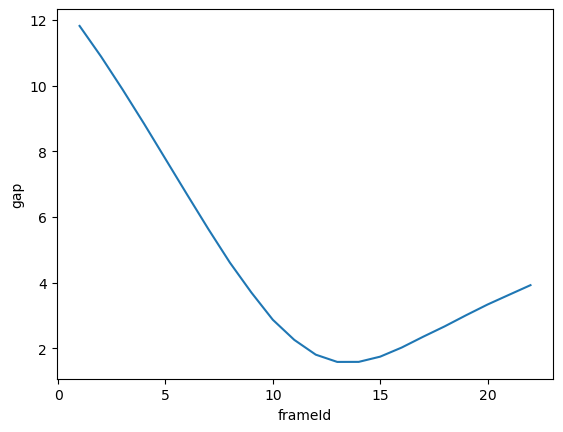

In [82]:
import seaborn as sns
sns.lineplot(data=temp, x='frameId', y='gap')

In [70]:
# temp.loc[temp.gap.idxmin()]
# temp.loc[temp.event=='tackle'].iloc[0]
# temp.loc[temp.gap <= (1.75 + 1e-5)].sort_values('frameId', ascending=True).iloc[0]
temp.gap[(temp.frameId>=10) & (temp.frameId <= 20)].min()


6.791060300129874

In [89]:
# get tackle event frameId
tackle_frame_id = temp.loc[temp.event=='tackle'].iloc[0].frameId
# create a boolean index for the 3 seconds of frames before the tackle
idx_contact_window = (temp.frameId >= max(1, tackle_frame_id - 30)) & (temp.frameId < tackle_frame_id)

if ((temp.event=='first_contact') & idx_contact_window).any():
    # get data for first contact frame
    first_contact_data = temp.loc[temp.event=='first_contact'].iloc[0]

    if first_contact_data.gap <= 3:  # threshold value - contact can be safely assumed to be the tackler
        contact_frame_id = first_contact_data.frameId

    else: # calculate an implicit first contact point between defender and runner within 3 seconds of tackle frame
        # get minimum gap within 3 seconds of the tackle
        min_gap = temp.gap[idx_contact_window].min()
        gap_for_contact = max(1.8, min_gap)  # if a wrap-up tackle, find the "threshold" frame (1.8). If a trip, allow for sensor error and find where they are closest and say that is contact frame
        # get earliest frame where gap is below contact threshold
        contact_data = temp.loc[idx_contact_window & (temp.gap <= (gap_for_contact + 1e-5))].sort_values('frameId', ascending=True).iloc[0]
        contact_frame_id = contact_data.frameId

else:  # fall back on non-first contact decision logic (first_contact not present in the 3 seconds before the tackle)
    # get minimum gap within 3 seconds of the tackle
    min_gap = temp.gap[idx_contact_window].min()
    gap_for_contact = max(1.8, min_gap)  # if a wrap-up tackle, find the "threshold" frame (1.8). If a trip, allow for sensor error and find where they are closest and say that is contact frame
    # get earliest frame where gap is below contact threshold
    contact_data = temp.loc[idx_contact_window & (temp.gap <= (gap_for_contact + 1e-5))].sort_values('frameId', ascending=True).iloc[0]
    contact_frame_id = contact_data.frameId


print(f'contact frame ID: {contact_frame_id}')
print(f'event at contact frame: {temp.event[temp.frameId==contact_frame_id].iloc[0]}')
print(f'gap at contact point: {temp.gap[temp.frameId==contact_frame_id].iloc[0]}')

contact frame ID: 11
event at contact frame: first_contact
gap at contact point: 2.254883589012969
